In [1]:
# Import libraries necessary for this project
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np
from sklearn.decomposition import pca

In [2]:
def pca_results(good_data, pca):
	'''
	Create a DataFrame of the PCA results
	Includes dimension feature weights and explained variance
	Visualizes the PCA results
	'''

	# Dimension indexing
	dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

	# PCA components
	components = pd.DataFrame(np.round(pca.components_, 4), columns = good_data.keys())
	components.index = dimensions

	# PCA explained variance
	ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
	variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
	variance_ratios.index = dimensions

	# Create a bar plot visualization
	fig, ax = plt.subplots(figsize = (14,8))

	# Plot the feature weights as a function of the components
	components.plot(ax = ax, kind = 'bar');
	ax.set_ylabel("Feature Weights")
	ax.set_xticklabels(dimensions, rotation=0)


	# Display the explained variance ratios
	for i, ev in enumerate(pca.explained_variance_ratio_):
		ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

	# Return a concatenated DataFrame
	return pd.concat([variance_ratios, components], axis = 1)


In [3]:
def cluster_results(reduced_data, preds, centers, pca_samples):
	'''
	Visualizes the PCA-reduced cluster data in two dimensions
	Adds cues for cluster centers and student-selected sample data
	'''

	predictions = pd.DataFrame(preds, columns = ['Cluster'])
	plot_data = pd.concat([predictions, reduced_data], axis = 1)

	# Generate the cluster plot
	fig, ax = plt.subplots(figsize = (14,8))

	# Color map
	cmap = cm.get_cmap('gist_rainbow')

	# Color the points based on assigned cluster
	for i, cluster in plot_data.groupby('Cluster'):   
	    cluster.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', \
	                 color = cmap((i)*1.0/(len(centers)-1)), label = 'Cluster %i'%(i), s=30);

	# Plot centers with indicators
	for i, c in enumerate(centers):
	    ax.scatter(x = c[0], y = c[1], color = 'white', edgecolors = 'black', \
	               alpha = 1, linewidth = 2, marker = 'o', s=200);
	    ax.scatter(x = c[0], y = c[1], marker='$%d$'%(i), alpha = 1, s=100);

	# Plot transformed sample points 
	ax.scatter(x = pca_samples[:,0], y = pca_samples[:,1], \
	           s = 150, linewidth = 4, color = 'black', marker = 'x');

	# Set plot title
	ax.set_title("Cluster Learning on PCA-Reduced Data - Centroids Marked by Number\nTransformed Sample Data Marked by Black Cross");



In [198]:
def channel_results(reduced_data, outliers, pca_samples):
	'''
	Visualizes the PCA-reduced cluster data in two dimensions using the full dataset
	Data is labeled by "Channel" and cues added for student-selected sample data
	'''

	# Check that the dataset is loadable
	try:
	    full_data = pd.read_csv("Wholesale customers data.csv")
	except:
	    print "Dataset could not be loaded. Is the file missing?"
	    return False

	# Create the Channel DataFrame
	channel = pd.DataFrame(full_data['Channel'], columns = ['Channel'])
	channel = channel.drop(channel.index[outliers]).reset_index(drop = True)
	labeled = pd.concat([reduced_data, channel], axis = 1)
	
	# Generate the cluster plot
	fig, ax = plt.subplots(figsize = (14,8))

	# Color map
	cmap = cm.get_cmap('gist_rainbow')

	# Color the points based on assigned Channel
	labels = ['Hotel/Restaurant/Cafe', 'Retailer']
	grouped = labeled.groupby('Channel')
	for i, channel in grouped:   
	    channel.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', \
	                 color = cmap((i-1)*1.0/2), label = labels[i-1], s=30);
	    
	# Plot transformed sample points   
	for i, sample in enumerate(pca_samples):
		ax.scatter(x = sample[0], y = sample[1], \
	           s = 200, linewidth = 3, color = 'black', marker = 'o', facecolors = 'none');
		ax.scatter(x = sample[0]+0.25, y = sample[1]+0.3, marker='$%d$'%(i), alpha = 1, s=125);

	# Set plot title
	ax.set_title("PCA-Reduced Data Labeled by 'Channel'\nTransformed Sample Data Circled");


In [5]:
from IPython.display import display # Allows the use of display() for DataFrames

In [6]:
# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

## 读入数据

In [45]:
data = pd.read_csv("Wholesale customers data.csv")

In [46]:
data.head(1)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338


In [47]:
data.drop(['Region', 'Channel'], axis = 1, inplace = True)

In [48]:
data.head(1)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338


## Visualizations, Feature relevance, Statistical description

In [11]:
# Display a description of the dataset
display(data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [12]:
# Column Names
data.keys()

Index([u'Fresh', u'Milk', u'Grocery', u'Frozen', u'Detergents_Paper',
       u'Delicassen'],
      dtype='object')

In [22]:
indices = [150,200,250]

# 把sample原来的序号去掉重新分配
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print "Chosen samples:"
display(samples)

Chosen samples:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,16225,1825,1765,853,170,1067
1,3067,13240,23127,3941,9959,731
2,3191,1993,1799,1730,234,710


#### Feature relevance
？？？要看购买一个category的时候是否会买另外一个category：
移除一个feature，训练一个监督式回归模型，用其余feature去预测这个被移除的feature，
如果得分高，说明它们之间有关系，否则没有强联系。

In [44]:
new_data = data
new_data.head(1)

,Fresh,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,7561,214,2674,1338


In [35]:
# 对 new_data 做的drop，还是会作用到data上
new_data.drop(['Milk'], axis = 1, inplace = True)

In [43]:
new_data.head(1)

,Fresh,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,7561,214,2674,1338


In [ ]:
data = pd.read_csv("Wholesale customers data.csv")
data.drop(['Region', 'Channel'], axis = 1, inplace = True)

In [39]:
# 分解数据集
from sklearn import cross_validation

In [53]:
y = data['Milk']
y.head(1)

0    9656
Name: Milk, dtype: int64

In [54]:
X = new_data

In [61]:
X.head(1)

,Fresh,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,7561,214,2674,1338


In [56]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size = 0.25, random_state = 0)

In [60]:
print len(X_train), len(X_test), len(y_train), len(y_test)

330 110 330 110


In [62]:
from sklearn import tree

In [63]:
regressor = tree.DecisionTreeRegressor()
regressor = regressor.fit(X_train, y_train)

In [65]:
score = regressor.score(X_test, y_test)

In [66]:
score

0.044580010749784349

### Feature Correlation
画出 6 个 feature 的散点矩阵，
如果某个 feature 对分类目标有显著的作用，那么它不会和其他feature有很大的关联，
相反，如果它和其他feature有关联，那么它对分类问题没太大贡献。

In [67]:
data.head(1)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338


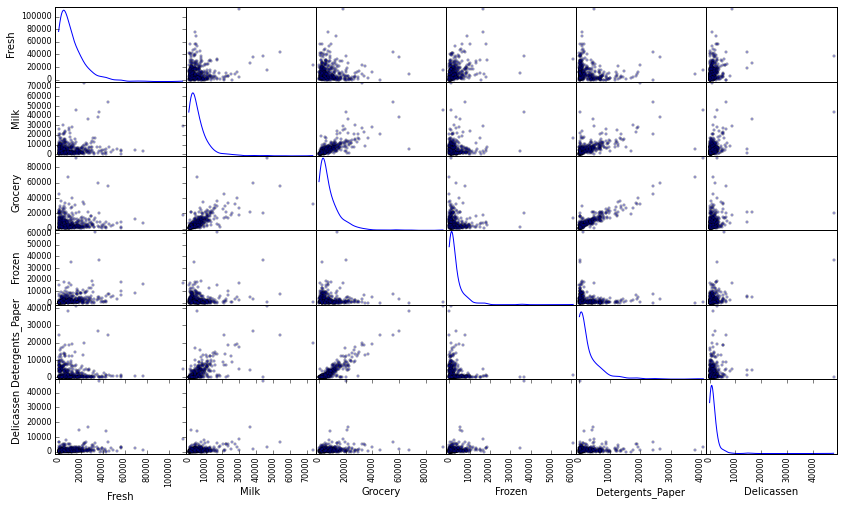

In [69]:
pd.scatter_matrix(data, alpha = 0.3, figsize = (14, 8), diagonal = 'kde');

### Preprocessing
scaling：当数据不符合正态分布的时候，需要做 scaling 的处理。常用的方法是取log。
outliers：方法之一是 Tukey 方法，小于  Q1 – (1.5 × IQR) 或者大于 Q3 + (1.5 × IQR) 就被看作是outlier。

In [70]:
data.head(1)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338


In [71]:
log_data = np.log(data)

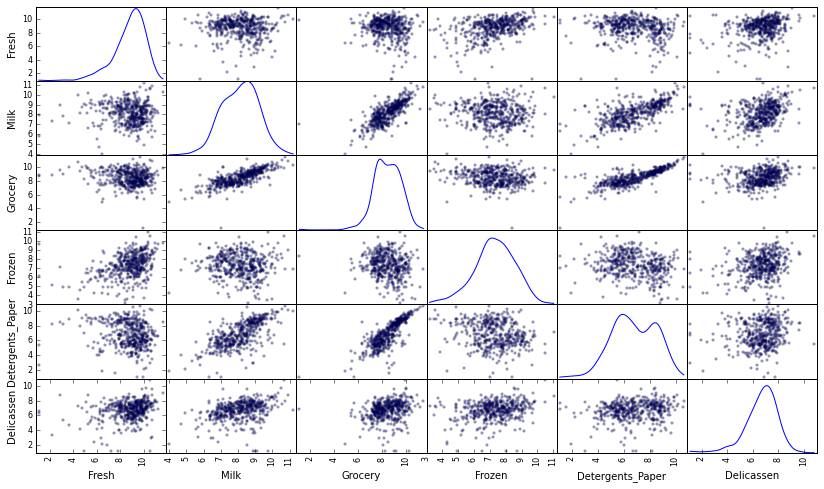

In [72]:
pd.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

In [74]:
log_data.head(1)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,9.446913,9.175335,8.930759,5.365976,7.891331,7.198931


In [104]:
for feature in log_data.keys():
    Q1 = np.percentile(log_data[feature], 25)
    Q3 = np.percentile(log_data[feature], 75)
    step = 1.5 * (Q3 - Q1)
    print "Outliers for feature '{}':".format(feature)
    print Q1, Q3, step
    display(log_data[~((log_data[feature]>=Q1-step) & (log_data[feature]<=Q3+step))].sort([feature]))

Outliers for feature 'Fresh':
8.04805870221 9.73706394795 2.53350786861


/Users/galphen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
95,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
338,1.098612,5.808142,8.856661,9.655090,2.708050,6.309918
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
218,2.890372,8.923191,9.629380,7.158514,8.475746,8.759669
96,3.135494,7.869402,9.001839,4.976734,8.262043,5.379897
357,3.610918,7.150701,10.011086,4.919981,8.816853,4.700480
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
412,4.574711,8.190077,9.425452,4.584967,7.996317,4.127134
353,4.762174,8.742574,9.961898,5.429346,9.069007,7.013016
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612


Outliers for feature 'Milk':
7.33498124004 8.88048008859 2.31824827282


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
98,6.220590,4.718499,6.656727,6.796824,4.025352,4.882802
356,10.029503,4.897840,5.384495,8.057377,2.197225,6.306275
86,10.039983,11.205013,10.377047,6.894670,9.906981,6.805723


Outliers for feature 'Grocery':
7.67461620137 9.27385367724 2.3988562138


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442


Outliers for feature 'Frozen':
6.60967774917 8.17589608318 2.34932750101


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
420,8.402007,8.569026,9.490015,3.218876,8.827321,7.239215
38,8.431853,9.663261,9.723703,3.496508,8.847360,6.070738
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
57,8.597297,9.203618,9.257892,3.637586,8.932213,7.156177
145,10.000569,9.034080,10.457143,3.737670,9.440738,8.396155
429,9.060331,7.467371,8.183118,3.850148,4.430817,7.824446
175,7.759187,8.967632,9.382106,3.951244,8.341887,7.436617
264,6.978214,9.177714,9.645041,4.110874,8.696176,7.142827
439,7.932721,7.437206,7.828038,4.174387,6.167516,3.951244
325,10.395650,9.728181,9.519735,11.016479,7.148346,8.632128


Outliers for feature 'Detergents_Paper':
5.54810142479 8.27434059875 4.08935876094


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
161,9.428190,6.291569,5.645447,6.995766,1.098612,7.711101


Outliers for feature 'Delicassen':
6.01187465693 7.50672842655 2.24228065442


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
109,7.248504,9.724899,10.274568,6.511745,6.728629,1.098612
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
187,7.798933,8.987447,9.192075,8.743372,8.148735,1.098612
233,6.871091,8.513988,8.106515,6.842683,6.013715,1.945910
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
184,5.789960,6.822197,8.457443,4.304065,5.811141,2.397895
203,6.368187,6.529419,7.703459,6.150603,6.860664,2.890372
285,10.602965,6.461468,8.188689,6.948897,6.077642,2.890372
289,10.663966,5.655992,6.154858,7.235619,3.465736,3.091042


In [83]:
log_data.head(1)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,9.446913,9.175335,8.930759,5.365976,7.891331,7.198931


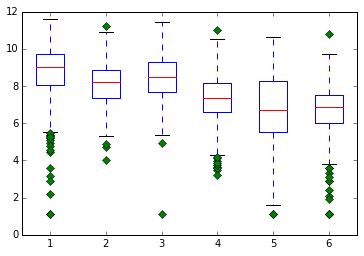

In [93]:
plt.figure()
plt.boxplot([log_data.Fresh, log_data.Milk, log_data.Grocery, log_data.Frozen, log_data.Detergents_Paper, log_data.Delicassen], 0, 'gD');

In [105]:
outliers = [109, 183, 75, 161, 154, 95, 338]

In [106]:
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)

### Principal Component analysis (PCA)
通过PCA可以找到最合适的 feature 的组合来描述数据。当然这个被组合而成的也被看作是数据的 feature。
每个维度都有一个 explained variance ratio，即数据的方差有多少是可以由这个维度来描述的。

In [110]:
from sklearn.decomposition import PCA

In [111]:
pca = PCA(n_components = 6)
pca.fit(good_data)

PCA(copy=True, n_components=6, whiten=False)

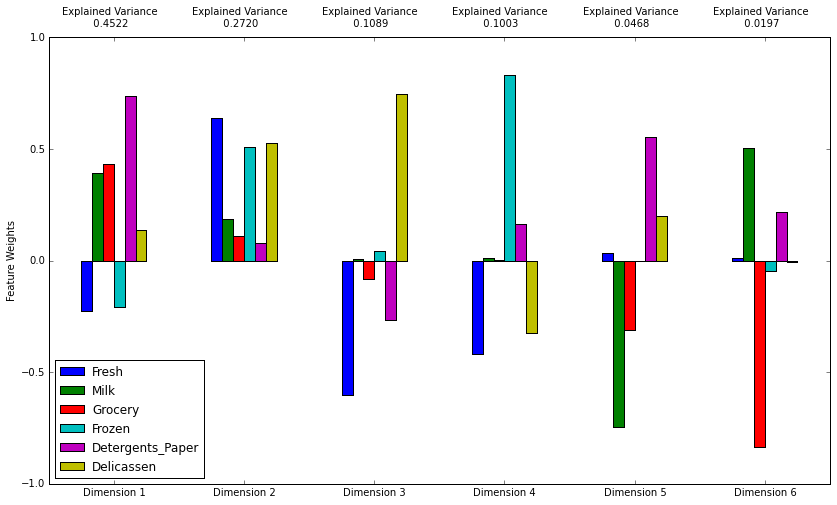

In [112]:
pca_results = pca_results(good_data, pca)

In [116]:
log_samples = np.log(samples)
log_samples

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,9.694309,7.509335,7.475906,6.748760,5.135798,6.972606
1,8.028455,9.490998,10.048756,8.279190,9.206232,6.594413
2,8.068090,7.597396,7.494986,7.455877,5.455321,6.565265


In [120]:
# 将数据X转换成降维后的数据。当模型训练好后，对于新输入的数据，都可以用transform方法来降维。
pca_samples = pca.transform(log_samples)
pca_samples

array([[-1.98360377,  0.11375447,  0.16596012, -1.22671644, -0.07522882,
         0.17690234],
       [ 2.91701208,  0.59289732, -0.32393616,  1.55408514, -0.24269065,
        -0.18194862],
       [-1.54459101, -0.73854262,  0.7868206 ,  0.22673878, -0.11124675,
         0.22489657]])

In [122]:
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,-1.9836,0.1138,0.1660,-1.2267,-0.0752,0.1769
1,2.9170,0.5929,-0.3239,1.5541,-0.2427,-0.1819
2,-1.5446,-0.7385,0.7868,0.2267,-0.1112,0.2249


In [124]:
# 上图中的纵轴所画
pca.components_

array([[ -2.23770781e-01,   3.91637001e-01,   4.34116028e-01,
         -2.09000094e-01,   7.38639493e-01,   1.37189762e-01],
       [  6.40339939e-01,   1.84471720e-01,   1.08940429e-01,
          5.09744555e-01,   7.84461772e-02,   5.27326859e-01],
       [ -6.03387941e-01,   7.75979532e-03,  -8.15726057e-02,
          4.15570151e-02,  -2.65805665e-01,   7.46209790e-01],
       [ -4.17552519e-01,   1.19989049e-02,   6.45121072e-04,
          8.32281584e-01,   1.62814750e-01,  -3.26043290e-01],
       [  3.61923545e-02,  -7.47489210e-01,  -3.09179179e-01,
         -4.89650434e-04,   5.51756324e-01,   1.99807278e-01],
       [  1.24257955e-02,   5.03633137e-01,  -8.35122138e-01,
         -4.53827057e-02,   2.16012872e-01,  -7.00900608e-03]])

In [125]:
pca.n_components_

6

In [126]:
# 上图中的图上方标注
pca.explained_variance_ 

array([ 4.53949079,  2.73104792,  1.09381021,  1.0073713 ,  0.47018512,
        0.19774327])

### 降维
由 cumulative explained variance ratio 判断需要多少维度。
如果数据可以被降维到 2-3 维，还可以可视化。

In [127]:
pca = PCA(n_components=2)

In [128]:
pca.fit(good_data)

PCA(copy=True, n_components=2, whiten=False)

In [129]:
reduced_data = pca.transform(good_data)

In [130]:
pca_samples = pca.transform(log_samples)

In [131]:
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

In [133]:
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,-1.9836,0.1138
1,2.9170,0.5929
2,-1.5446,-0.7385


### 聚类
用 silhouette coefficient 计算每个数据到中心点的距离，-1 (dissimilar) to 1 (similar)
根据这个系数来评价聚类算法的优劣。

In [134]:
from sklearn.cluster import KMeans

In [136]:
cluster = KMeans(n_clusters=2, random_state=0).fit(reduced_data)

In [138]:
preds = cluster.predict(reduced_data)

In [143]:
# preds - cluster.labels_

In [147]:
centers = cluster.cluster_centers_
centers

array([[-1.49143632,  0.06631663],
       [ 2.19880326, -0.09776965]])

In [148]:
sample_preds = cluster.predict(pca_samples)
sample_preds

array([0, 1, 0], dtype=int32)

In [149]:
from sklearn.metrics import silhouette_score

In [151]:
score = silhouette_score(reduced_data, preds)
score

0.42928910092639655

In [157]:
for i in range(2, 7):
    cluster = KMeans(n_clusters=i, random_state=0).fit(reduced_data)
    preds = cluster.predict(reduced_data)
    score = silhouette_score(reduced_data, preds)
    print "Score for cluster '{}':".format(i)
    print score

Score for cluster '2':
0.429289100926
Score for cluster '3':
0.403903460167
Score for cluster '4':
0.335880540456
Score for cluster '5':
0.356798505281
Score for cluster '6':
0.3622507466


In [159]:
centers

array([[-1.49143632,  0.06631663],
       [ 2.19880326, -0.09776965]])

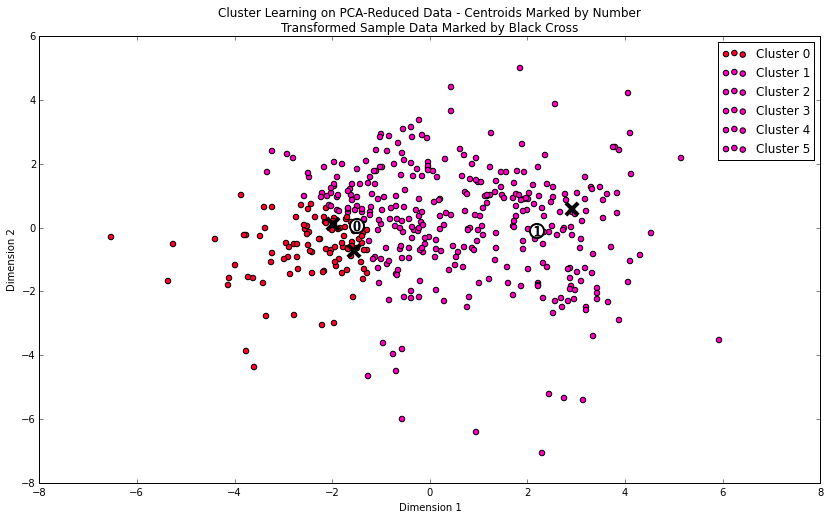

In [158]:
cluster_results(reduced_data, preds, centers, pca_samples)

### 恢复维度
前面的数据，先经过 log，又经过 PCA降维，
要恢复回去，先用 pca.inverse_transform，再用 np.exp

In [160]:
centers

array([[-1.49143632,  0.06631663],
       [ 2.19880326, -0.09776965]])

In [161]:
log_centers = pca.inverse_transform(centers)
log_centers

array([[ 9.14224385,  7.56144014,  7.8232009 ,  7.64378349,  5.74274691,
         6.50757878],
       [ 8.21140506,  8.97640522,  9.40731742,  6.78888098,  8.45563165,
         6.92731476]])

In [162]:
true_centers = np.exp(log_centers)
true_centers

array([[  9341.70298829,   1922.61235308,   2497.88812659,   2087.62740425,
           311.9200501 ,    670.20174445],
       [  3682.71325962,   7914.1313843 ,  12177.16091598,    887.91940836,
          4701.47539009,   1019.75202487]])

In [163]:
segments = ['Segment {}'.format(i) for i in range(0, len(centers))]
segments

['Segment 0', 'Segment 1']

In [164]:
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,9342.0,1923.0,2498.0,2088.0,312.0,670.0
1,3683.0,7914.0,12177.0,888.0,4701.0,1020.0


In [165]:
true_centers.index = segments
display(true_centers)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Segment 0,9342.0,1923.0,2498.0,2088.0,312.0,670.0
Segment 1,3683.0,7914.0,12177.0,888.0,4701.0,1020.0


In [185]:
true_centers.sum(axis=1)

Segment 0    16833.0
Segment 1    30383.0
dtype: float64

### 通过各category的比例看顾客类别的不同

In [189]:
true_centers.ix[0]/16833.0

Fresh               0.554981
Milk                0.114240
Grocery             0.148399
Frozen              0.124042
Detergents_Paper    0.018535
Delicassen          0.039803
Name: Segment 0, dtype: float64

In [190]:
true_centers.ix[1]/30383.0

Fresh               0.121219
Milk                0.260475
Grocery             0.400783
Frozen              0.029227
Detergents_Paper    0.154725
Delicassen          0.033571
Name: Segment 1, dtype: float64

把各个数据的分类加进数据集

In [202]:
# Display the predictions
for i, pred in enumerate(sample_preds):
    print "Sample point", i, "predicted to be in Cluster", pred

Sample point 0 predicted to be in Cluster 0
Sample point 1 predicted to be in Cluster 1
Sample point 2 predicted to be in Cluster 0


In [204]:
sample_preds

array([0, 1, 0], dtype=int32)

In [205]:
samples['Segment'] = sample_preds

In [206]:
samples

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Segment
0,16225,1825,1765,853,170,1067,0
1,3067,13240,23127,3941,9959,731,1
2,3191,1993,1799,1730,234,710,0


Q10:
If the wholesale distributor is considering changing its delivery service from currently 5 days a week to 3 days a week, Segment 0 will react negatively, since Fresh is their most purchasing part, and it requires to be fresh, so the delivery should be in time.

Q11:
The 'customer segment' driven by clustering algorithm can now be a label, if there are 10 new customers with data describing their annual spending of each product category, we can choose a supervised learner to train the origin customers' spendings and segments, then predict new customers' segments.

In [196]:
pca_samples

array([[-1.98360377,  0.11375447],
       [ 2.91701208,  0.59289732],
       [-1.54459101, -0.73854262]])

### Visualizing Underlying Distributions
By reintroducing the 'Channel' feature to the dataset, an interesting structure emerges when considering the same PCA dimensionality reduction applied earlier to the original dataset.

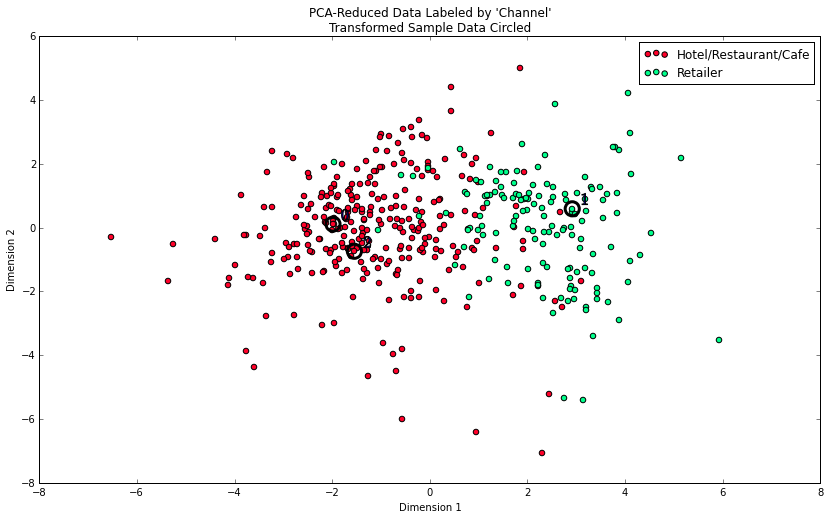

In [199]:
channel_results(reduced_data, outliers, pca_samples)